# Unet-Pytorch
Este proyecto nace con la idea de tener una alternativa a la implementación de U-Net en Tensorflow. La idea es que sea lo más parecida posible a la implementación de Tensorflow, pero en Pytorch.

## Importar librerías

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os, random, torch, shutil, cv2
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import random_split, DataLoader, Dataset
import glob

import PIL, skimage.io
from PIL import Image

from lxml import etree


## Comprobar si hay GPU

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Directorios

In [14]:
# Localización de los frames
annotation_file = "data/annotations.xml"
frames_dir = "data/frames/"
train_location = "data/train/"
mask_location = "data/mask/"
frames = os.listdir(frames_dir)

print(len(frames))
labels = {"acera":0,
          "ciclovia":0,
          "cruceZebra":0}


2892


In [15]:
frames[:5]

['calzada_galvan_0.jpg',
 'calzada_galvan_1.jpg',
 'calzada_galvan_10.jpg',
 'calzada_galvan_100.jpg',
 'calzada_galvan_1000.jpg']

## Creación del dataset

In [16]:
class Unet_Dataset(Dataset):
  def __init__(self, data, masks=None, img_transform=None, mask_transform=None):
    '''
    data - train data path
    masks - train masks path
    '''
    self.train_data = data
    self.train_masks = masks
    
    self.img_transform = img_transform
    self.mask_transform = mask_transform
    
    self.images = sorted(os.listdir(self.train_data))
    self.masks = sorted(os.listdir(self.train_masks))
    
  def __len__(self):
    if self.train_masks is not None:
      assert len(self.images) == len(self.masks), "Images and masks must have the same length"
    return len(self.images)
  
  def __getitem__(self, idx):
    image_name = os.path.join(self.train_data, self.images[idx])
    img = Image.open(image_name)
    trans = T.ToTensor()
    if self.img_transform is not None:
      
      img = self.img_transform(img)
    else:
      # En caso de no tener transformaciones, se convierte a tensor de PyTorch
      img = trans(img)
    
    if self.train_masks is not None:
      mask_name = os.path.join(self.train_masks, self.masks[idx])
      mask = Image.open(mask_name)
      
      if self.mask_transform is not None:
        mask = self.mask_transform(mask)
      else:
        # En caso de no tener transformaciones, se convierte a tensor de PyTorch
        mask = trans(mask)
      
      # Normalizamos la mascara, sabiendo que solo hay 3 clases
      mask_max = mask.max().item()
      mask /= mask_max
      
    else:
      return img
    
    return img, mask

## Transformaciones

In [17]:
# Definimos las transformaciones para las imagenes y las mascaras
# Por ahora solo redimensionamos a 224x224, pero se pueden agregar mas
# transformaciones como rotaciones, recortes, etc.
transform_data = T.Compose([
  T.Resize((224, 224)),
  T.ToTensor()])

## Dataloader

In [18]:
full_dataset = Unet_Dataset(
  data=train_location, 
  masks=mask_location, 
  img_transform=transform_data,
  mask_transform=transform_data)

BATCH_SIZE = 32
TRAIN_SIZE = int(0.8 * len(full_dataset))
VAL_SIZE = len(full_dataset) - TRAIN_SIZE  # Datos de validación

print("Datos de entrenamiento: ", TRAIN_SIZE)
print("Datos de validación: ", VAL_SIZE)

Datos de entrenamiento:  2182
Datos de validación:  546


In [19]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
len(train_dataset), len(val_dataset)

(2182, 546)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


In [22]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


## Visualización de imágenes

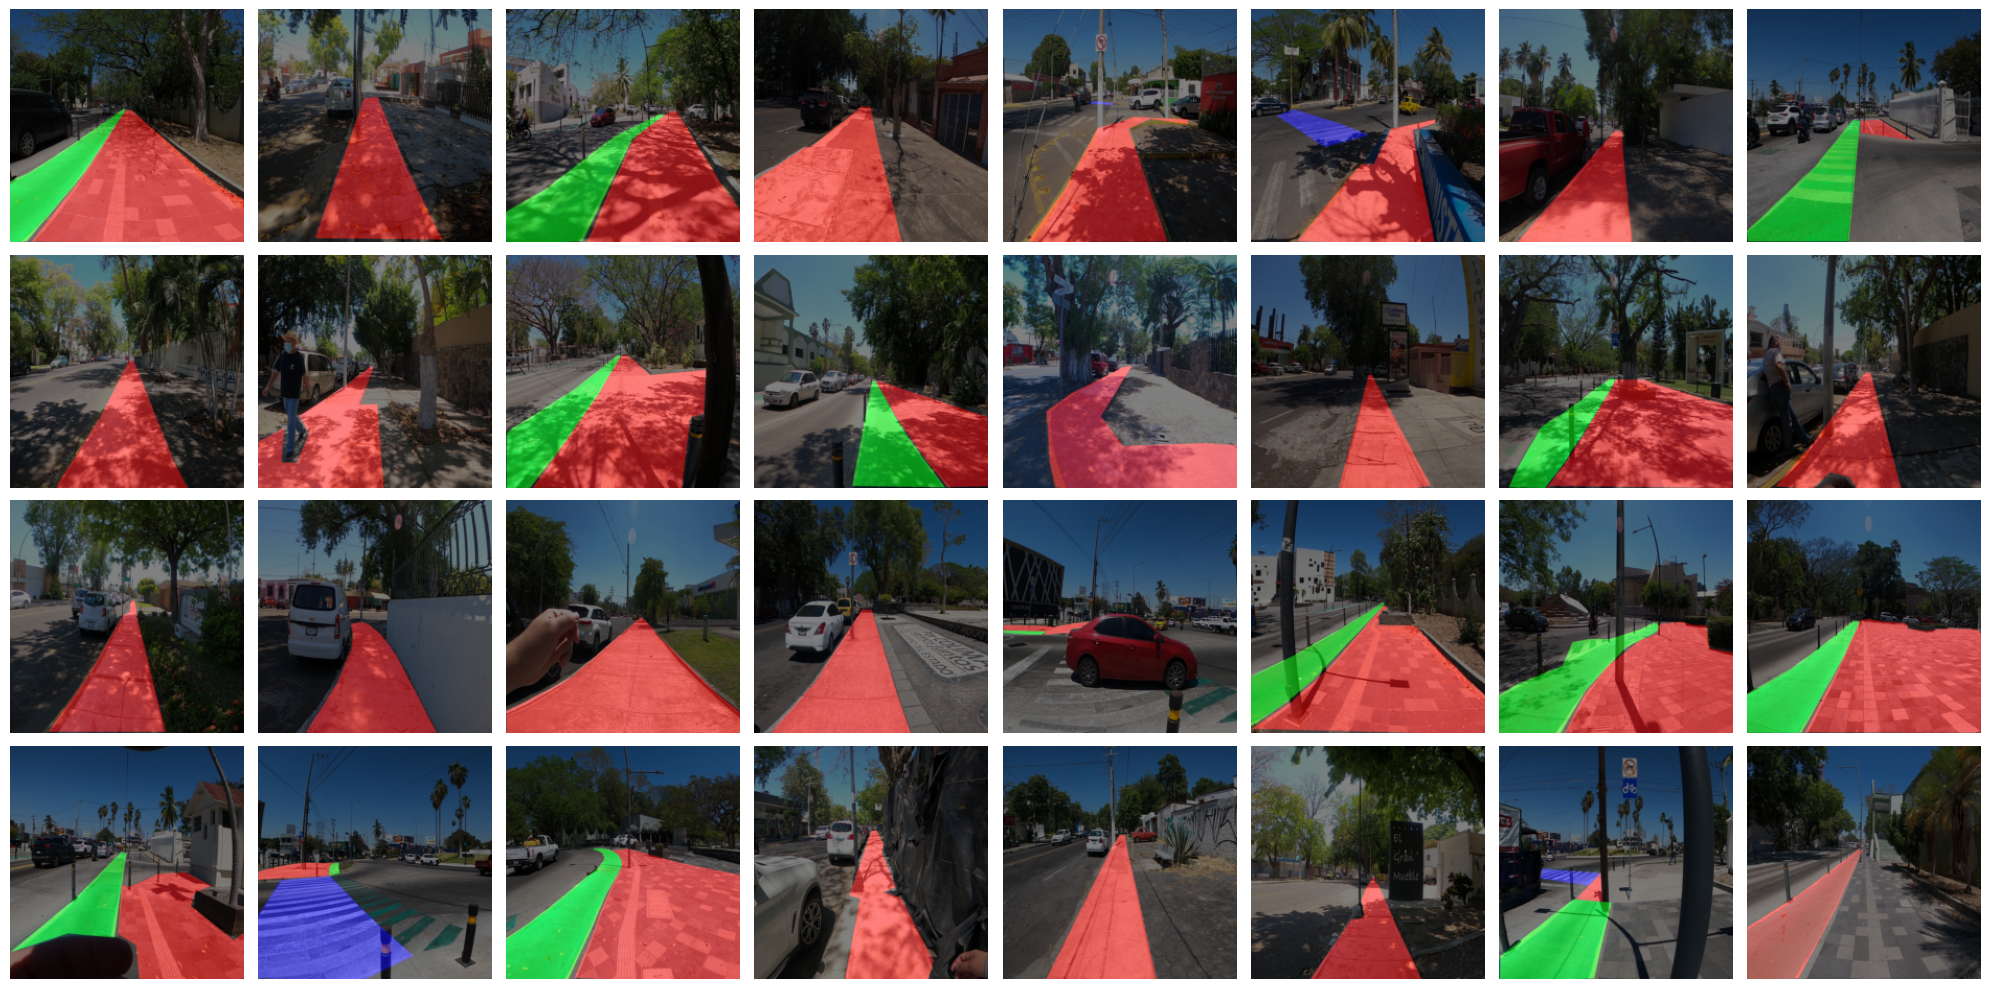

In [23]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

### Accuracy

In [24]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou   

In [25]:
len(train_loader)

69

### Modelo U-Net

In [26]:
class Conv_3_k(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    # 3 capas convolucionales con kernel 3x3 y padding 1
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
  def forward(self, x):
    x = self.conv1(x)
    return x

In [27]:
class Double_Conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    
    self.double_conv = nn.Sequential(
      Conv_3_k(in_channels, out_channels),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      
      Conv_3_k(out_channels, out_channels),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
    )
      
  def forward(self, x):
    return self.double_conv(x)

In [28]:
class Down_Conv(nn.Module):
  """Down Convolutional Block

  Args:
      nn (_type_): _description_
  """
  
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.MaxPool2d(2,2),
      Double_Conv(in_channels, out_channels)
    )
  
  def forward(self, x):
    return self.encoder(x)

In [29]:
class Up_Conv(nn.Module):
  """Up Convolutional Block

  Args:
      nn (_type_): _description_
  """
  def __init__(self, in_channels, out_channels):
    super().__init__()
    
    self.upsample_layer = nn.Sequential(
      nn.Upsample(scale_factor=2, mode='bicubic'),
      # https://youtu.be/x_cY9l1cwj0?t=1231
      nn.Conv2d(in_channels, in_channels//2, kernel_size=1, stride=1),
    )
    
    self.decoder = Double_Conv(in_channels, out_channels)
  
  # Se usa el x1 y x2 para concatenarlos, x1 es el output de la capa de abajo
  # y x2 es el output de la capa de la izquierda
  def forward(self, x1, x2):
    """Up Convolutional Block

    Args:
        x1 (_type_): Upsample volume
        x2 (_type_): Volume from down sampling to concatenate

    Returns:
        _type_: _description_
    """
    x1 = self.upsample_layer(x1)
    
    # dim 1 es porque concatenamos en el canal 1 de las imagenes
    # las imagenes vienen de la forma (channels, height, width)
    x = torch.cat([x2, x1], dim=1)
    
    return self.decoder(x)
  
  


In [30]:
class UNET(nn.Module):
  """UNET"""
  
  def __init__(self, in_channels, channels, num_classes):
    super().__init__()
    self.first_conv = Double_Conv(in_channels, channels) # 64, 224, 224
    self.down_conv1 = Down_Conv(channels, channels*2) # 128, 112, 112
    self.down_conv2 = Down_Conv(channels*2, channels*4) # 256, 56, 56
    self.down_conv3 = Down_Conv(channels*4, channels*8) # 512, 28, 28
    
    self.middle_conv = Down_Conv(channels*8, channels*16) # 1024, 14, 14
    
    self.up_conv1 = Up_Conv(channels*16, channels*8) # 512, 28, 28
    self.up_conv2 = Up_Conv(channels*8, channels*4) # 256, 56, 56
    self.up_conv3 = Up_Conv(channels*4, channels*2) # 128, 112, 112
    self.up_conv4 = Up_Conv(channels*2, channels) # 64, 224, 224
    
    self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
    
  def forward(self, x):
    x1 = self.first_conv(x)
    x2 = self.down_conv1(x1)
    x3 = self.down_conv2(x2)
    x4 = self.down_conv3(x3)
    
    x5 = self.middle_conv(x4)
    
    u1 = self.up_conv1(x5, x4)
    u2 = self.up_conv2(u1, x3)
    u3 = self.up_conv3(u2, x2)
    u4 = self.up_conv4(u3, x1)
    
    return self.last_conv(u4)

In [34]:
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

In [35]:
preds = test()

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 64, 224, 224] to have 3 channels, but got 64 channels instead

In [ ]:
print(preds.shape)

NameError: name 'preds' is not defined